In [1]:
import pandas as pd
from datetime import datetime

In [2]:
df = pd.read_csv('../../data/current.csv')
# df = pd.read_csv('../../training_data.csv')
df.head()
df.shape


(2133, 22)

### Cleaning

In [3]:
df.drop(df['skaterFullName'].loc[df['skaterFullName'] == 'Taylor Hall'].index, inplace=True)
df = df.drop(columns=['skaterFullName', 'teamAbbrevs', 'vs', 'shoots', 'row', 'date']) 
df = df.dropna()
df.head()

,ppPoints,gamesPlayed,position,ppUnit,avgPowerplayToi,team_PEN/GP,team_PP%,team_PK%,team_G,team_GA,enemy_PEN/GP,enemy_PP%,enemy_PK%,enemy_G,enemy_GA,scored
0,0,9,L,2.0,1:39,4.5,15.6,97.4,31.0,16.0,4.73,28.6,83.3,40,33,0
1,0,10,D,1.0,1:58,4.5,15.6,97.4,31.0,16.0,4.73,28.6,83.3,40,33,1
2,3,10,L,2.0,3:38,4.5,15.6,97.4,31.0,16.0,4.73,28.6,83.3,40,33,0
3,4,10,R,1.0,3:46,4.5,15.6,97.4,31.0,16.0,4.73,28.6,83.3,40,33,1
4,0,10,C,2.0,1:07,4.5,15.6,97.4,31.0,16.0,4.73,28.6,83.3,40,33,1


In [4]:
df['avgPowerplayToi'] = df['avgPowerplayToi'].apply(lambda x: datetime.strptime(str(x), "%M:%S").second + datetime.strptime(str(x), "%M:%S").minute * 60)

df['position'].replace(['C', 'R', 'L', 'D'], [2, 2, 2, 1], inplace=True)
df.head()

,ppPoints,gamesPlayed,position,ppUnit,avgPowerplayToi,team_PEN/GP,team_PP%,team_PK%,team_G,team_GA,enemy_PEN/GP,enemy_PP%,enemy_PK%,enemy_G,enemy_GA,scored
0,0,9,2,2.0,99,4.5,15.6,97.4,31.0,16.0,4.73,28.6,83.3,40,33,0
1,0,10,1,1.0,118,4.5,15.6,97.4,31.0,16.0,4.73,28.6,83.3,40,33,1
2,3,10,2,2.0,218,4.5,15.6,97.4,31.0,16.0,4.73,28.6,83.3,40,33,0
3,4,10,2,1.0,226,4.5,15.6,97.4,31.0,16.0,4.73,28.6,83.3,40,33,1
4,0,10,2,2.0,67,4.5,15.6,97.4,31.0,16.0,4.73,28.6,83.3,40,33,1


### Visualization

Players who scored:  392
Players who did not score:  1665


C:\Users\Logan\AppData\Local\Temp\ipykernel_25904\326808471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=concat, data=df, palette='hls')


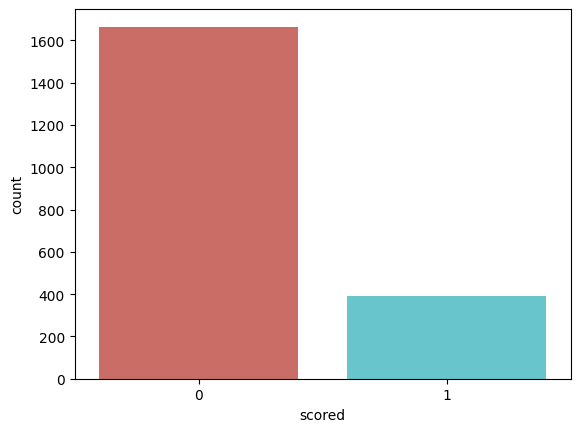

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

labels=['scored', 'no-score']

scored = df[df['scored'] == 1]['scored']
no_score = df[df['scored'] == 0]['scored']

concat = pd.concat([scored, no_score])

sns.countplot(x=concat, data=df, palette='hls')
print('Players who scored: ', len(scored))
print('Players who did not score: ', len(no_score))

In [6]:
perc = (scored.shape[0] / df['scored'].shape[0]) * 100
print(f'Percentage of players with a scored point ({scored.shape[0]}/{df["scored"].shape[0]}): {round(perc, 2)}%')

Percentage of players with a scored point (392/2057): 19.06%


### Neural Network

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from keras.callbacks import EarlyStopping


In [8]:
features = ['ppPoints', 'gamesPlayed', 'avgPowerplayToi', 'team_PEN/GP', 'team_PP%', 'team_PK%', 'team_GA', 'team_G', 'enemy_PEN/GP', 'enemy_PP%', 'enemy_PK%', 'enemy_GA', 'enemy_G']

biases = {
    'ppPoints': 2.5,
    'gamesPlayed': 0.5,
    'avgPowerplayToi': 2.6,
    'team_PEN/GP': 0.0,
    'team_PP%': 2.5,
    'team_PK%': 0.0,
    'team_GA': 0.0,
    'team_G': 0.3,
    'enemy_PEN/GP': 2.5,
    'enemy_PP%': 0.0,
    'enemy_PK%': 2.6,
    'enemy_GA': 0.4,
    'enemy_G': 0.0
}

# scaler = MinMaxScaler()
# scaler.fit(df[features])
# df[features] = scaler.transform(df[features])

scaler = StandardScaler()
scaler.fit(df[features])
df[features] = scaler.transform(df[features])

# df[features] = df[features].apply(lambda x: x + biases[x.name])

X = df[features].values
y = df['scored'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and transform the training data using the RandomUnderSampler
# X_train, y_train = undersampler.fit_resample(X_train, y_train)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)

model = Sequential()
model.add(Dense(128))
model.add(LSTM(512, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision()])

tf.random.set_seed(42)
history = model.fit(X_train, y_train, epochs=65, batch_size=256, validation_data=(X_test, y_test), verbose=1, shuffle=True)

(2330, 1, 13)


Epoch 1/65

10/10 [==============================] - 2s 55ms/step - loss: 0.6747 - precision: 0.6032 - val_loss: 0.7004 - val_precision: 0.2526
Epoch 2/65
10/10 [==============================] - 0s 15ms/step - loss: 0.6540 - precision: 0.6179 - val_loss: 0.6646 - val_precision: 0.2717
Epoch 3/65
10/10 [==============================] - 0s 15ms/step - loss: 0.6492 - precision: 0.6244 - val_loss: 0.6793 - val_precision: 0.2518
Epoch 4/65
10/10 [==============================] - 0s 15ms/step - loss: 0.6442 - precision: 0.6188 - val_loss: 0.6842 - val_precision: 0.2632
Epoch 5/65
10/10 [==============================] - 0s 15ms/step - loss: 0.6378 - precision: 0.6417 - val_loss: 0.6659 - val_precision: 0.2714
Epoch 6/65
10/10 [==============================] - 0s 16ms/step - loss: 0.6334 - precision: 0.6430 - val_loss: 0.6557 - val_precision: 0.2672
Epoch 7/65
10/10 [==============================] - 0s 15ms/step - loss: 0.6292 - precision: 0.6413 - val_loss: 0.6450 - val_

In [9]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_test)

# Adjust the threshold
threshold = 0.9 # You can experiment with different threshold values
y_pred_labels = (y_pred_probs > threshold).astype(int)

print(f'threshold of {threshold*100}%')
print(classification_report(y_test, y_pred_labels))

y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
print('Regular threshold')
print(classification_report(y_test, y_pred))

20/20 [==============================] - 0s 1ms/step
threshold of 90.0%
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       500
           1       0.51      0.19      0.28       118

    accuracy                           0.81       618
   macro avg       0.67      0.58      0.59       618
weighted avg       0.77      0.81      0.77       618

20/20 [==============================] - 0s 1ms/step
Regular threshold
              precision    recall  f1-score   support

           0       0.90      0.82      0.85       500
           1       0.44      0.60      0.51       118

    accuracy                           0.78       618
   macro avg       0.67      0.71      0.68       618
weighted avg       0.81      0.78      0.79       618



In [10]:
# model.save('model.h5')

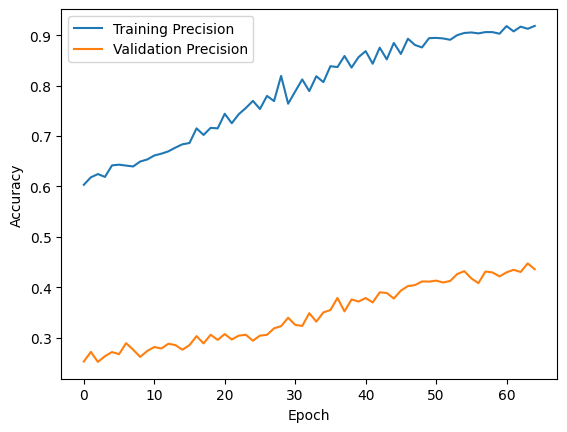

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Player List Prediction

In [12]:
df = pd.read_csv('../../../../lib/ai_bum_list.csv')
df.drop(df['skaterFullName'].loc[df['skaterFullName'] == 'Taylor Hall'].index, inplace=True)
df = df.drop(columns=['skaterFullName', 'teamAbbrevs', 'vs', 'shoots', 'row', 'date']) 
df = df.dropna()

df['avgPowerplayToi'] = df['avgPowerplayToi'].apply(lambda x: datetime.strptime(str(x), "%M:%S").second + datetime.strptime(str(x), "%M:%S").minute * 60)

df['position'].replace(['C', 'R', 'L', 'D'], [2, 2, 2, 1], inplace=True)
df.head()
df.shape

(170, 36)

In [13]:
list_df = pd.read_csv('../../../../lib/ai_bum_list.csv')

list_df.drop(list_df['skaterFullName'].loc[list_df['skaterFullName'] == 'Taylor Hall'].index, inplace=True)
list_df['avgPowerplayToi'] = list_df['avgPowerplayToi'].apply(lambda x: datetime.strptime(str(x), "%M:%S").second + datetime.strptime(str(x), "%M:%S").minute * 60)

features = ['ppPoints', 'gamesPlayed', 'avgPowerplayToi', 'team_PEN/GP', 'team_PP%', 'team_PK%', 'team_GA', 'team_G', 'enemy_PEN/GP', 'enemy_PP%', 'enemy_PK%', 'enemy_GA', 'enemy_G']

list_df[features] = scaler.transform(list_df[features])

# Iterate over each row and reshape
reshaped_data_list = []
for index, row in list_df.iterrows():
    reshaped_data = row[features].values.reshape(1, 1, 13)
    reshaped_data_list.append(reshaped_data)


# Convert the list to a NumPy array
reshaped_data_array = np.array(reshaped_data_list, dtype=np.float32)

predictions = []
for i in reshaped_data_array:
    pred = model.predict(i, verbose=0)
    predictions.append(pred[0][0])

# Return scaled data to normal
list_df['prediction'] = predictions

list_df[features] = scaler.inverse_transform(list_df[features])
list_df.sort_values(by='prediction', ascending=False).to_csv('rnn_preds.csv')


In [14]:
pred_list = pd.read_csv('rnn_preds.csv')


display = ['skaterFullName', 'teamAbbrevs', 'ppPoints', 'ppUnit', 'team_PP%', 'vs', 'enemy_PP%', 'enemy_PK%', 'prediction'] # ',odds'

pred_list['prediction'] = pred_list['prediction'].apply(lambda x: round(x, 5))

# Grab only the top predictions based on the threshold
top_threshold = pred_list[pred_list['prediction'] > threshold]

print(f'Threshold of {threshold*100}%')

Threshold of 90.0%


In [15]:
# odds = [
#     2.0,
#     2.2,
#     2.4,
# ]

# top_threshold['odds'] = odds
# top_threshold[display]

top_threshold[display]

,skaterFullName,teamAbbrevs,ppPoints,ppUnit,team_PP%,vs,enemy_PP%,enemy_PK%,prediction
